In [18]:
from omero.gateway import BlitzGateway
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
import napari
import pandas as pd
from scipy import ndimage as ndi
from skimage import measure
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects


In [19]:
conn = BlitzGateway('helfrid', 'Omero_21', host='ome2.hpc.susx.ac.uk')
conn.connect()

True

In [29]:
object= conn.getObject("Image", 302177)
pixels=object.getPrimaryPixels()

imgDAPI=pixels.getPlane(0,0,0)

(-0.5, 1079.5, 1079.5, -0.5)

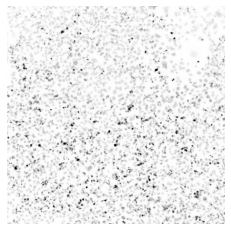

In [30]:

plt.imshow(imgDAPI, cmap='Greys')
plt.axis('off')

In [31]:
#@param ["Cytoplasm","Cytoplasm2", "Cytoplasm2_Omnipose", "Bacteria_Omnipose", "Nuclei"]


In [32]:

model = models.CellposeModel(gpu=False, model_type = 'nuclei')
channels = [[0,0]]
masks, flows, styles = model.eval(imgDAPI, diameter=15, channels=channels)

In [33]:
def make_bbox(bbox_extents):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    minr = bbox_extents[0]
    minc = bbox_extents[1]
    maxr = bbox_extents[2]
    maxc = bbox_extents[3]

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

def Napari_Display(image, segmented_cells, cell_number):
    """

    Display Image in Napari Viewer. Segmented cells and rectangles around segmented cells
   :param image: Image, Segmented Cells, and Cell Number
    """
    properties = measure.regionprops_table(
        segmented_cells, properties=('label', 'bbox')
    )
    # create the bounding box rectangles
    bbox_rects = make_bbox([properties[f'bbox-{i}'] for i in range(4)])

    viewer=napari.Viewer()
    viewer.add_image(image)
    viewer.add_labels(segmented_cells, name=f'segmentation {cell_number} of cells')
    viewer.add_shapes(
        bbox_rects,
        face_color='transparent',
        edge_color='orange',
        properties=properties,
        name='bounding box',
    )


In [34]:
Napari_Display(imgDAPI, masks, masks.max())